In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import os

# constantes
SEED = 224601816
BURN_IN = 1000
THINNING = 10
SAVE = True
FILEPATH = os.getcwd()

Generamos $\mu$ de una distribución semi-normal con varianza $\sigma^2=10$. 

Por el teorema de Bayes, tenemos que

$$p(\mu|x_1,\ldots,x_n)=\frac{p(x_1,\ldots,x_n|\mu)p(\mu)}{p(x_1,\ldots,x_n)}=\frac{p(x_1|\mu)\cdot\ldots\cdot p(x_n|\mu)p(\mu)}{p(x_1,\ldots,x_n)},$$

donde $p(x_i|\mu)\sim\mathcal N(\mu,5)$ y $p(\mu)\sim|\mathcal N(0,10)|$.

In [2]:
def normal_pdf(x, mean, var):
    return np.exp( -(x - mean)**2 / (2*var)) / np.sqrt(2*np.pi*var)

def Metropolis_Hastings(mu_0, n_samples, p, prior, burn_in=BURN_IN, thinning=THINNING):
    # Inicializamos
    mu_t = mu_0
    samples = []

    for i in range(thinning*n_samples + burn_in):
        mu_candidate = np.random.normal(mu_t, 1)
        
        # Calculamos el numerador y denominador de p(mu|x), en logaritmo
        with np.errstate(divide='ignore'):
            N = np.log(prior(mu_candidate)) + np.sum(np.log(p(x, mu_candidate)))
        D = np.log(prior(mu_t)) + np.sum(np.log(p(x, mu_t)))
        
        # Calculamos la probabilidad de aceptación
        log_accept_prob =  N - D
        
        # Comparamos con una uniforme y actualizamos
        u = np.random.uniform(0,1)
        
        if np.log(u) < log_accept_prob:
            mu_t = mu_candidate
        
        samples.append(mu_t)
    return np.array(samples), np.array(samples[burn_in::thinning])

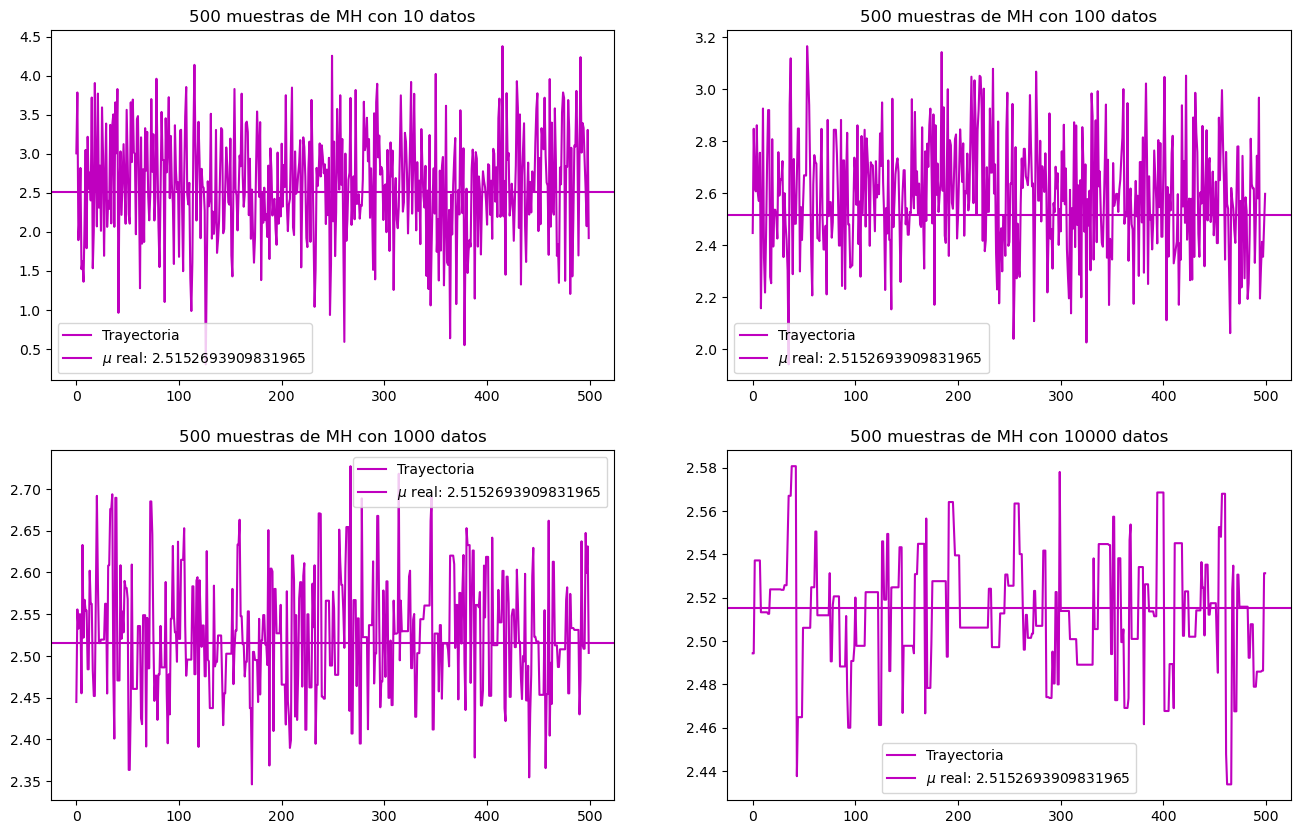

In [9]:
np.random.seed(SEED)

prior = lambda u: 2*normal_pdf(u, mean=0, var=10) if u>0 else 0
p = lambda x, u: normal_pdf(x, mean=u, var=5)

# Simulamos mu según una semi-normal
mu = np.abs(np.random.normal(loc=0, scale=np.sqrt(10)))
n = [10, 100, 1000, 10000]
m = 500

mu_0 = 10

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

for i, ax in enumerate(axes.flatten()):
    # Generamos datos
    x = np.random.normal(loc=mu, scale=np.sqrt(5), size=n[i])
    _, samples = Metropolis_Hastings(mu_0, m, p, prior)
  
    ax.set_title(f"{m} muestras de MH con {n[i]} datos")
    ax.plot(samples, color='m', label='Trayectoria')
    ax.axhline(mu, color='m', label=fr'$\mu$ real: {mu}')
    ax.legend()
    
if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\trajectories_1d.pdf', bbox_inches='tight')
    
plt.show()

Ahora queremos repetir el proceso donde $$x_i\sim\sum_{j=1}^n\lambda_j\mathcal N(\mu_j,5)$$

Elegiremos $(\lambda_1,\lambda_2,\lambda_3)$ fijos de modo que $\lambda_1+\lambda_2+\lambda_3=1$ y samplearemos $\mu\sim\text{MVN}(0,\Sigma)$ con $\Sigma$ diagonal (es decir, $\mu_1,\mu_2,\mu_3$ independientes).

En este caso, la distribución a simular está dada por

$$p(\mu|x_1,\ldots,x_n)=\frac{p(x_1,\ldots,x_n|\mu)p(\mu)}{p(x_1,\ldots,x_n)}=\frac{p(x_1|\mu)\cdot\ldots\cdot p(x_n|\mu)p(\mu)}{p(x_1,\ldots,x_n)},$$

donde hemos denotado $\mu=(\mu_1,\mu_2,\mu_3)$

Como $\mu_1,\mu_2,\mu_3$ son independientes, entonces $x_i\sim\sum_{j=1}^3\mathcal N(\lambda_j\mu_j,5\lambda_j^2)$, es decir, $p(x_i|\mu)=\mathcal N(\sum_j\lambda_j\mu_j,\sum_j5\lambda_j^2)=\mathcal N(\lambda^T\mu,5|\lambda|^2)$

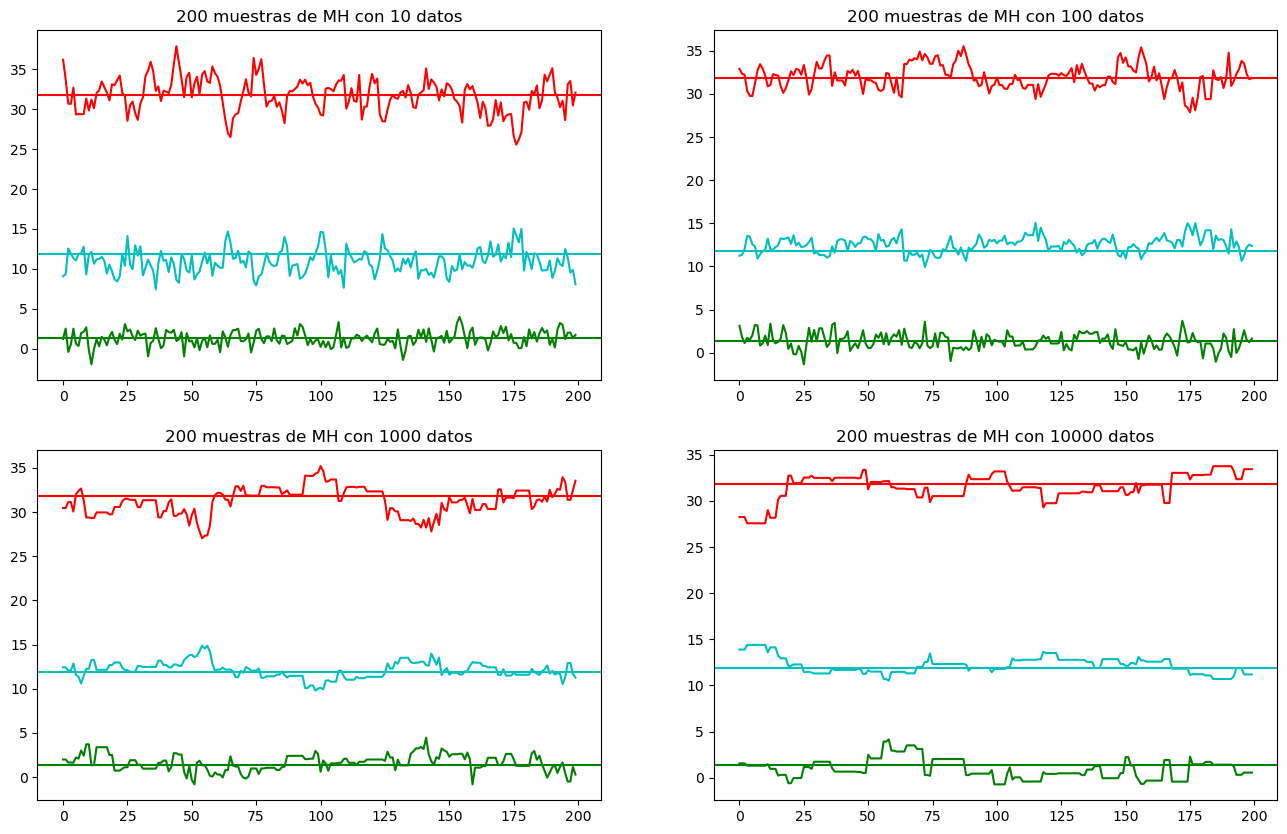

In [4]:
np.random.seed(SEED)

mean = [1,10,30]
cov = [[1,0,0],
       [0,3,0],
       [0,0,5]]

prior = lambda u: sp.multivariate_normal.pdf(x=u, mean=mean, cov=cov)
p = lambda x, u: normal_pdf(x, mean=np.dot(lambda_, u), var=5*np.linalg.norm(lambda_))

# Simulamos mu según una normal multivariada
mu = np.random.multivariate_normal(mean=mean, cov=cov)
lambda_ = [0.2, 0.5, 0.3]

n = [10, 100, 1000, 10000]
m = 200

mu_0 = [10, 10, 10]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

for i, ax in enumerate(axes.flatten()):
    # Generamos datos
    x = np.random.normal(loc=np.dot(lambda_, mu), scale=np.sqrt(5*np.linalg.norm(lambda_)), size=n[i])
    _, samples = Metropolis_Hastings(mu_0, m, p, prior)
    
    ax.set_title(f"{m} muestras de MH con {n[i]} datos")
    ax.plot(samples[:,0], color='g')
    ax.plot(samples[:,1], color='c')
    ax.plot(samples[:,2], color='r')
    ax.axhline(mu[0], color='g')
    ax.axhline(mu[1], color='c')
    ax.axhline(mu[2], color='r')
    
if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\trajectories_3d.pdf', bbox_inches='tight')
    
plt.show()